Este código genera los dataset de DB3, para las particiones de datos por sujeto y por repetición.

In [1]:
import numpy as np
import pickle
import joblib
import pandas as pd
import sys
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.utils.class_weight import compute_class_weight
from sklearn.impute import SimpleImputer
import os

# Levanto los datos del Experimento 1

In [2]:
ruta_datos = "../data/"
# Cargo datos
os.chdir(ruta_datos) # me situo en el directorio
file = open('data_gestos_puntuales_fs200_DB3.pickle', 'rb')
MyoArm_data = pickle.load(file)
file.close()

## Extracción de datos y corrección de etiquetas

In [3]:
data = MyoArm_data['data']
label = MyoArm_data['label']
subject = MyoArm_data['subject']
nOfSubjects = 11

In [4]:
values, counts = np.unique(label, return_counts=True)
print(values)   # imprimo valores de etiquetas
print(counts)   # imprimo la cantidad de datos de cada etiqueta

[ 0  5  6  7  9 10 13 14 22 26 31]
[1903645   69264   69408   69342   69415   68690   69347   69613   68545
   68807   63080]


In [5]:
# Creo un diccionario de mapeo para los valores de etiqueta
mapeo = {0: 0, 5: 1, 6: 2, 7: 3, 9: 4, 10: 5, 13: 6, 14: 7, 22: 8, 26: 9, 31: 10}

# Hago el reemplazo de las etiquetas
label = np.vectorize(mapeo.get)(label)

# Rellenado de datos

Hago un rellenado de datos según el criterio explicado en el informe.

In [6]:
def aplicar_imputer(data, label):
  # calculo desviacion estandar sobre los datos de reposo
  ind_reposo = np.where(label==0)[0]

  std_reposo = np.nanstd(data[ind_reposo], axis=0)
  mean_reposo = np.nanmean(data[ind_reposo], axis=0)

  # Rellenar manualmente los NaN en cada columna con los valores de relleno
  for i in range(data.shape[1]):
      nan_mask = np.isnan(data[:, i])  # Máscara de los NaN en la columna i
      data[nan_mask, i] = std_reposo[i]*np.random.normal() + mean_reposo[i]  # Reemplazar los NaN por el valor de relleno correspondiente

  return data

data = aplicar_imputer(data, label)

# Chequeo si hay alguna etiqueta nan
nan_indices = np.isnan(data)
np.where(nan_indices==True)

(array([], dtype=int64), array([], dtype=int64))

# Partición de datos por sujeto

In [7]:
# hago una lista de Dataframes
list_data_x_sujeto = []
list_label_x_sujeto = []

for i in range(1, nOfSubjects+1):  # luego podría no hardcodearlo
  ind_sujeto_act = np.where(subject==i)[0]
  list_data_x_sujeto.append(data[ind_sujeto_act])
  list_label_x_sujeto.append(label[ind_sujeto_act])

## Cálculo de pesos

In [ ]:
# para cada sujeto armo un Dataset con las secuencias de datos y etiquetas

list_labels_dataset_x_sujeto = []

for j in range(nOfSubjects):#
  label_j = list_label_x_sujeto[j]

  input_sequence_length = 650 # Cada gesto dura 5s aprox, y el incremento es de 50ms

  label_dataset = tf.keras.utils.timeseries_dataset_from_array(
          data=label_j,  # excluimos los últimos target_sequence_length elementos de los datos
          targets=None,
          sequence_length=input_sequence_length,
          batch_size=None,   # multiplo de 8
          sequence_stride = 5
        )

  secuencias_labels_list = []

  for x in label_dataset:
    secuencias_labels_list.append(x)

  selected_secuencias_labels_list = []

  contador_reposos = 0

  for i in range(len(secuencias_labels_list)):  # len(secuencias_labels_list)
    unique_values, counts = np.unique(secuencias_labels_list[i], return_counts=True)
    # Encontrar el valor que más se repite
    max_count_index = np.argmax(counts)
    most_frequent_value = unique_values[max_count_index]
    counts_most_frequent = counts[max_count_index]

    if most_frequent_value==0:
      contador_reposos += 1

    if (((counts_most_frequent/len(secuencias_labels_list[i])) == 1) and (most_frequent_value != 0)):
      selected_secuencias_labels_list.append(most_frequent_value)

  list_labels_dataset_x_sujeto.extend(selected_secuencias_labels_list)
  
  unique_values, counts = np.unique(list_labels_dataset_x_sujeto, return_counts=True)
# Calcula los pesos de clase
class_weights = compute_class_weight(class_weight='balanced',
                                    classes=np.unique(list_labels_dataset_x_sujeto), y=np.array(list_labels_dataset_x_sujeto))
# Convierte los pesos a un diccionario
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

print("Pesos de clase:", class_weights_dict)

joblib.dump(class_weights_dict, "pesos_x_sujeto.pkl")

## Generación de datasets sin normalización


In [ ]:
# Función para unir datos de entrada, labels y vector de pesos
def combine_features_labels_weights(features, sample_weights):
    inputs, labels = features
    return inputs, labels, sample_weights

In [ ]:
for j in range(nOfSubjects):#
  label_j = list_label_x_sujeto[j]
  data_j = list_data_x_sujeto[j]

  input_sequence_length = 650 # Cada gesto dura 5s aprox, y el incremento es de 50ms

  label_dataset = tf.keras.utils.timeseries_dataset_from_array(
          data=label_j,  # excluimos los últimos target_sequence_length elementos de los datos
          targets=None,
          sequence_length=input_sequence_length,
          batch_size=None,   # multiplo de 8
          sequence_stride = 5
        )
  data_dataset = tf.keras.utils.timeseries_dataset_from_array(
          data=data_j,  # excluimos los últimos target_sequence_length elementos de los datos
          targets=None,
          sequence_length=input_sequence_length,
          batch_size=None,   # multiplo de 8
          sequence_stride = 5
        )

  secuencias_labels_list = []
  secuencias_data_list = []

  for x in label_dataset:
    secuencias_labels_list.append(x)

  for x in data_dataset:
    secuencias_data_list.append(x)

  selected_secuencias_labels_list = []
  selected_secuencias_data_list = []

  contador_reposos = 0

  for i in range(len(secuencias_labels_list)):  # len(secuencias_labels_list)
    unique_values, counts = np.unique(secuencias_labels_list[i], return_counts=True)
    # Encontrar el valor que más se repite
    max_count_index = np.argmax(counts)
    most_frequent_value = unique_values[max_count_index]
    counts_most_frequent = counts[max_count_index]

    if most_frequent_value==0:
      contador_reposos += 1

    if (((counts_most_frequent/len(secuencias_labels_list[i])) == 1) and (most_frequent_value != 0)):
      selected_secuencias_labels_list.append(most_frequent_value)
      selected_secuencias_data_list.append(secuencias_data_list[i])

  selected_secuencias_labels_array = np.array(selected_secuencias_labels_list)

  # Crear una matriz de pesos de la misma forma que y_train
  sample_weight = np.zeros(selected_secuencias_labels_array.shape)

  selected_secuencias_labels_array = selected_secuencias_labels_array - 1

  # Asignar los pesos de clase a cada timestep en la secuencia
  for i, class_weight in class_weights_dict.items():
      sample_weight[selected_secuencias_labels_array == i] = class_weight

  # Convertir las listas en tensores de TensorFlow
  tensores = tf.stack(selected_secuencias_data_list)
  etiquetas = tf.convert_to_tensor(list(selected_secuencias_labels_array))

  sample_weight_tensor = tf.convert_to_tensor(sample_weight, dtype=tf.float32)
  sample_weight_dataset = tf.data.Dataset.from_tensor_slices(sample_weight_tensor)

  # Crear un dataset a partir de los tensores y etiquetas
  input_dataset = tf.data.Dataset.from_tensor_slices((tensores, etiquetas))


  rnn_dataset_j = tf.data.Dataset.zip((input_dataset, sample_weight_dataset))
  rnn_dataset_j_def = rnn_dataset_j.map(combine_features_labels_weights)

  # Guardar el dataset
  rnn_dataset_j_def.save("dataset_GI_sin_reposo_650_stride5_crudo_sub"+str(j))

# Partición de datos por repetición

In [10]:
# Calculo cantidad de repeticiones de cada gesto
flancos = np.diff(label)  # Con estos flancos puedo dividir las repeticiones
rep_starts_ind = np.where(flancos>0)[0]
rep_ends_ind = np.where(flancos<0)[0]

# etiqueto cada repetición
etiqueta_repeticion = []
indices_repeticion = []

for i in range(1, 11):
  rep_start_ind = np.where(flancos==i)[0]
  rep_end_ind = np.where(flancos==-i)[0]
  for j in range(len(rep_start_ind)):
    indices_repeticion.append(np.arange(rep_start_ind[j], rep_end_ind[j]))
    etiqueta_repeticion.append(i)

## Cálculo de pesos
Esto lo tengo que ejecutar sólo una vez para generar pesos.pkl

In [14]:
# para cada sujeto armo un Dataset con las secuencias de datos y etiquetas
list_input_dataset_x_sujeto = []
list_labels_dataset_x_sujeto = []

for j in range(nOfSubjects): #
  label_j = list_label_x_sujeto[j]

  input_sequence_length = 650 # Cada gesto dura 5s aprox, y el incremento es de 50ms

  label_dataset = tf.keras.utils.timeseries_dataset_from_array(
          data=label_j,  # excluimos los últimos target_sequence_length elementos de los datos
          targets=None,
          sequence_length=input_sequence_length,
          batch_size=None,   # multiplo de 8
          sequence_stride = 5
        )

  secuencias_labels_list = []

  for x in label_dataset:
    secuencias_labels_list.append(x)

  selected_secuencias_labels_list = []

  contador_reposos = 0

  for i in range(len(secuencias_labels_list)):  # len(secuencias_labels_list)
    unique_values, counts = np.unique(secuencias_labels_list[i], return_counts=True)
    # Encontrar el valor que más se repite
    max_count_index = np.argmax(counts)
    most_frequent_value = unique_values[max_count_index]
    counts_most_frequent = counts[max_count_index]

    if most_frequent_value==0:
      contador_reposos += 1

    if (((counts_most_frequent/len(secuencias_labels_list[i])) == 1) and (most_frequent_value != 0)):
      selected_secuencias_labels_list.append(most_frequent_value)

In [15]:
unique_values, counts = np.unique(selected_secuencias_labels_list, return_counts=True)
# Calcula los pesos de clase
class_weights = compute_class_weight(class_weight='balanced',
                                    classes=np.unique(selected_secuencias_labels_list), y=np.array(selected_secuencias_labels_list))
# Convierte los pesos a un diccionario
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

print("Pesos de clase:", class_weights_dict)

joblib.dump(class_weights_dict, "pesos.pkl")

Pesos de clase: {0: np.float64(0.9926315789473684), 1: np.float64(0.9843423799582464), 2: np.float64(0.9989406779661016), 3: np.float64(0.9864016736401674), 4: np.float64(1.0408388520971303), 5: np.float64(0.9843423799582464), 6: np.float64(0.9721649484536082), 7: np.float64(1.0385462555066078), 8: np.float64(1.025), 9: np.float64(0.9822916666666667)}


['pesos.pkl']

## Generación de datasets

In [17]:
# función para identificar a qué repetición corresponde una secuencia
def find_most_similar_array_index(target_array, list_of_arrays):
  max_common_elements = 0
  most_similar_index = -1

  for index, array in enumerate(list_of_arrays):
      # Convert both arrays to sets
      target_set = set(target_array)
      array_set = set(array)

      # Find the number of common elements
      common_elements = len(target_set.intersection(array_set))

      # Update the most similar array index if this one has more common elements
      if common_elements > max_common_elements:
          max_common_elements = common_elements
          most_similar_index = index

  return most_similar_index

# levanto los pesos calculados
class_weights_dict = joblib.load("pesos.pkl")

### Con normalización

In [19]:
def combine_features_labels_weights(features, sample_weights):
    inputs, labels = features
    return inputs, labels, sample_weights

In [ ]:
guardar_ds = True

nombre_exp = "dataset_E1_DB3_normalizado_sub"

for j in range(nOfSubjects):
  data_j = list_data_x_sujeto[j]
  label_j = list_label_x_sujeto[j]

  flancos = np.diff(label_j)  # Con estos flancos puedo dividir las repeticiones
  rep_starts_ind = np.where(flancos>0)[0]
  rep_ends_ind = np.where(flancos<0)[0]

  etiqueta_repeticion = []
  indices_repeticion = []

  etiqueta_repeticion = label_j[rep_ends_ind]

  for k in range(len(rep_starts_ind)):
    # deberia quedarme del mismo largo que etiqueta_repeticion
    indices_k = np.arange(rep_starts_ind[k], rep_ends_ind[k]) # creo un vector de indices tomando el inicio y fin
    indices_repeticion.append(indices_k)
  # Crear los bordes de los bins para que estén centrados en 0, 1, ..., 9
  bins = np.arange(0.5, 11.5, 1)

  # # Generar el histograma
  # plt.figure()
  # plt.hist(label_j[rep_ends_ind], bins=bins, edgecolor='black', rwidth=0.8)
  # plt.grid(True)
  # plt.xticks(np.arange(1,11))  # Asegurarse de que los ticks estén en los enteros de 0 a 9
  # plt.xlabel('Gesto')
  # plt.ylabel('Cantidad repeticiones')
  # plt.title('Cantidad de repeticion por gesto en sujeto '+str(i))
  indices_label = np.arange(0, len(label_j))

  input_sequence_length = 650 # Cada gesto dura 5s aprox, y el incremento es de 50ms

  label_dataset = tf.keras.utils.timeseries_dataset_from_array(
          data=label_j,  # excluimos los últimos target_sequence_length elementos de los datos
          targets=None,
          sequence_length=input_sequence_length,
          batch_size=None,   # multiplo de 8
          sequence_stride = 5
        )

  data_dataset = tf.keras.utils.timeseries_dataset_from_array(
          data=data_j,  # excluimos los últimos target_sequence_length elementos de los datos
          targets=None,
          sequence_length=input_sequence_length,
          batch_size=None,   # multiplo de 8
          sequence_stride = 5
        )

  indices_dataset = tf.keras.utils.timeseries_dataset_from_array(
          data=indices_label,  # excluimos los últimos target_sequence_length elementos de los datos
          targets=None,
          sequence_length=input_sequence_length,
          batch_size=None,   # multiplo de 8
          sequence_stride = 5
        )

  secuencias_labels_list = []
  secuencias_data_list = []
  indices_dataset_list = []

  for x in label_dataset:
    secuencias_labels_list.append(x)

  for x in data_dataset:
    secuencias_data_list.append(x)

  for x in indices_dataset:
    indices_dataset_list.append(x)

  selected_secuencias_labels_list = []
  selected_secuencias_data_list = []
  selected_secuencias_indices_list = []
  valores = []

  contador_reposos = 0

  for i in range(len(secuencias_labels_list)):  # len(secuencias_labels_list)
    unique_values, counts = np.unique(secuencias_labels_list[i], return_counts=True)
    # Encontrar el valor que más se repite
    max_count_index = np.argmax(counts)
    most_frequent_value = unique_values[max_count_index]
    counts_most_frequent = counts[max_count_index]
    valores.append(most_frequent_value)
    if most_frequent_value==0:
      contador_reposos += 1

    if (((counts_most_frequent/len(secuencias_labels_list[i])) == 1) and (most_frequent_value != 0)):
      selected_secuencias_labels_list.append(most_frequent_value)
      selected_secuencias_data_list.append((secuencias_data_list[i]-np.mean(secuencias_data_list[i]))/np.std(secuencias_data_list[i]))
      selected_secuencias_indices_list.append(indices_dataset_list[i])

  selected_secuencias_labels_array = np.array(selected_secuencias_labels_list)
  selected_secuencias_labels_array = selected_secuencias_labels_array - 1
  # armo vector de pesos

  # Crear una matriz de pesos de la misma forma que y_train
  sample_weight = np.zeros(selected_secuencias_labels_array.shape)
  # Asignar los pesos de clase a cada timestep en la secuencia
  for i, class_weight in class_weights_dict.items():
      sample_weight[selected_secuencias_labels_array == i] = class_weight

  # asignacion de repeticiones a secuencias

  correspondencia_repe = []

  for i in range(len(selected_secuencias_indices_list)):
      # Convertir tensores a listas
      if isinstance(selected_secuencias_indices_list[i], tf.Tensor):
          target_array = selected_secuencias_indices_list[i].numpy().tolist()
      else:
          target_array = selected_secuencias_indices_list[i].tolist()

      list_of_arrays = []
      for array in indices_repeticion:
          if isinstance(array, tf.Tensor):
              list_of_arrays.append(array.numpy().tolist())
          else:
              list_of_arrays.append(array.tolist())

      most_similar_index = find_most_similar_array_index(target_array, list_of_arrays)
      correspondencia_repe.append(most_similar_index)

  repeticiones_encontradas = np.unique(correspondencia_repe)

  secuencias_repeticiones_encontradas = []  # en cada elemento quedan los indices de las secuencias de cada repe
  # me puedo fijar la etiqueta mirando la variable etiqueta_repeticion

  for i in repeticiones_encontradas:
    ind_secuencias_repeticion_i = np.where(correspondencia_repe==i)[0]
    secuencias_repeticiones_encontradas.append(ind_secuencias_repeticion_i)

  if len(secuencias_repeticiones_encontradas) != len(etiqueta_repeticion):
    print('Revisar secuencias_repeticiones_encontradas o etiqueta_repeticion')


  # Armo 6 folds porque tengo 6 repeticiones de cada gesto
# Armo 6 folds porque tengo 6 repeticiones de cada gesto
    # voy a usar la logica de repartir las repeticiones por cada fold
  folds_list = [[], [], [], [], [], []]

  # voy a ir repartiendo las repeticiones gesto a gesto
  gesto_actual = 1
  ind_receptor = 0  # el indice del fold qe recibe una repetición

  # necesito una condicion que chequee que no tenga mas repeticiones que folds
  # por ahora voy a suponer que tengo maximo 6 repeticiones en cada gesto

  for i in range(len(secuencias_repeticiones_encontradas)):
    # print(i)
    if gesto_actual != etiqueta_repeticion[i]:
      gesto_actual = etiqueta_repeticion[i]
      # cambio_gesto = True
      ind_receptor = 0
      #print(ind_receptor)
      folds_list[ind_receptor].append(secuencias_repeticiones_encontradas[i])
      ind_receptor += 1
    else:
      # cambio_gesto = False

      # print(ind_receptor)
      folds_list[ind_receptor].append(secuencias_repeticiones_encontradas[i])
      ind_receptor += 1

  # lo que sigue tengo que pasarlo a funciones
  fold_list0 = folds_list[0]
  fold_list1 = folds_list[1]
  fold_list2 = folds_list[2]
  fold_list3 = folds_list[3]
  fold_list4 = folds_list[4]
  fold_list5 = folds_list[5]

  flattened_fold_list0 = np.concatenate(fold_list0)
  flattened_fold_list1 = np.concatenate(fold_list1)
  flattened_fold_list2 = np.concatenate(fold_list2)
  flattened_fold_list3 = np.concatenate(fold_list3)
  flattened_fold_list4 = np.concatenate(fold_list4)
  flattened_fold_list5 = np.concatenate(fold_list5)


# fold 0
  secuencias_data_array_fold_0 = np.array(selected_secuencias_data_list)[flattened_fold_list0]
  secuencias_labels_array_fold_0 = selected_secuencias_labels_array[flattened_fold_list0]

  secuencias_data_list_fold_0 = list(secuencias_data_array_fold_0)
  secuencias_labels_list_fold_0 = list(secuencias_labels_array_fold_0)

  secuencias_weight_array_fold_0 = sample_weight[flattened_fold_list0]
  secuencias_weight_list_fold_0 = list(secuencias_weight_array_fold_0)
# fold 1
  secuencias_data_array_fold_1 = np.array(selected_secuencias_data_list)[flattened_fold_list1]
  secuencias_labels_array_fold_1 = selected_secuencias_labels_array[flattened_fold_list1]

  secuencias_data_list_fold_1 = list(secuencias_data_array_fold_1)
  secuencias_labels_list_fold_1 = list(secuencias_labels_array_fold_1)

  secuencias_weight_array_fold_1 = sample_weight[flattened_fold_list1]
  secuencias_weight_list_fold_1 = list(secuencias_weight_array_fold_1)

# fold 2
  secuencias_data_array_fold_2 = np.array(selected_secuencias_data_list)[flattened_fold_list2]
  secuencias_labels_array_fold_2 = selected_secuencias_labels_array[flattened_fold_list2]
  secuencias_data_list_fold_2 = list(secuencias_data_array_fold_2)
  secuencias_labels_list_fold_2 = list(secuencias_labels_array_fold_2)

  secuencias_weight_array_fold_2 = sample_weight[flattened_fold_list2]
  secuencias_weight_list_fold_2 = list(secuencias_weight_array_fold_2)

# fold 3
  secuencias_data_array_fold_3 = np.array(selected_secuencias_data_list)[flattened_fold_list3]
  secuencias_labels_array_fold_3 = selected_secuencias_labels_array[flattened_fold_list3]
  secuencias_data_list_fold_3 = list(secuencias_data_array_fold_3)
  secuencias_labels_list_fold_3 = list(secuencias_labels_array_fold_3)

  secuencias_weight_array_fold_3 = sample_weight[flattened_fold_list3]
  secuencias_weight_list_fold_3 = list(secuencias_weight_array_fold_3)

# fold 4
  secuencias_data_array_fold_4 = np.array(selected_secuencias_data_list)[flattened_fold_list4]
  secuencias_labels_array_fold_4 = selected_secuencias_labels_array[flattened_fold_list4]
  secuencias_data_list_fold_4 = list(secuencias_data_array_fold_4)
  secuencias_labels_list_fold_4 = list(secuencias_labels_array_fold_4)

  secuencias_weight_array_fold_4 = sample_weight[flattened_fold_list4]
  secuencias_weight_list_fold_4 = list(secuencias_weight_array_fold_4)

# fold 5
  secuencias_data_array_fold_5 = np.array(selected_secuencias_data_list)[flattened_fold_list5]
  secuencias_labels_array_fold_5 = selected_secuencias_labels_array[flattened_fold_list5]
  secuencias_data_list_fold_5 = list(secuencias_data_array_fold_5)
  secuencias_labels_list_fold_5 = list(secuencias_labels_array_fold_5)

  secuencias_weight_array_fold_5 = sample_weight[flattened_fold_list5]
  secuencias_weight_list_fold_5 = list(secuencias_weight_array_fold_5)

  sample_weight_tensor_0 = tf.convert_to_tensor(secuencias_weight_array_fold_0, dtype=tf.float32)
  sample_weight_dataset_0 = tf.data.Dataset.from_tensor_slices(sample_weight_tensor_0)

  # Convertir las listas en tensores de TensorFlow
  tensores = tf.stack(secuencias_data_list_fold_0)
  etiquetas = tf.convert_to_tensor(list(secuencias_labels_array_fold_0))

  # Crear un dataset a partir de los tensores y etiquetas
  input_dataset = tf.data.Dataset.from_tensor_slices((tensores, etiquetas))
  rnn_dataset_j = tf.data.Dataset.zip((input_dataset, sample_weight_dataset_0))
  rnn_dataset_j_def = rnn_dataset_j.map(combine_features_labels_weights)

  if guardar_ds:
    rnn_dataset_j_def.save(nombre_exp+str(j)+"_weighted_fold_rep_0")


  # secuencias_labels_array_fold_1 = secuencias_labels_array_fold_1 - 1
  sample_weight_tensor_1 = tf.convert_to_tensor(secuencias_weight_array_fold_1, dtype=tf.float32)
  sample_weight_dataset_1 = tf.data.Dataset.from_tensor_slices(sample_weight_tensor_1)

  # Convertir las listas en tensores de TensorFlow
  tensores = tf.stack(secuencias_data_list_fold_1)
  etiquetas = tf.convert_to_tensor(list(secuencias_labels_array_fold_1))
  # Crear un dataset a partir de los tensores y etiquetas
  input_dataset = tf.data.Dataset.from_tensor_slices((tensores, etiquetas))
  rnn_dataset_j = tf.data.Dataset.zip((input_dataset, sample_weight_dataset_1))
  rnn_dataset_j_def = rnn_dataset_j.map(combine_features_labels_weights)

  if guardar_ds:
    rnn_dataset_j_def.save(nombre_exp+str(j)+"_weighted_fold_rep_1")


  sample_weight_tensor_2 = tf.convert_to_tensor(secuencias_weight_array_fold_2, dtype=tf.float32)
  sample_weight_dataset_2 = tf.data.Dataset.from_tensor_slices(sample_weight_tensor_2)
  # Convertir las listas en tensores de TensorFlow
  tensores = tf.stack(secuencias_data_list_fold_2)
  etiquetas = tf.convert_to_tensor(list(secuencias_labels_array_fold_2))

  # Crear un dataset a partir de los tensores y etiquetas
  input_dataset = tf.data.Dataset.from_tensor_slices((tensores, etiquetas))
  rnn_dataset_j = tf.data.Dataset.zip((input_dataset, sample_weight_dataset_2))
  rnn_dataset_j_def = rnn_dataset_j.map(combine_features_labels_weights)

  if guardar_ds:
    rnn_dataset_j_def.save(nombre_exp+str(j)+"_weighted_fold_rep_2")


  # secuencias_labels_array_fold_3 = secuencias_labels_array_fold_3 - 1
  sample_weight_tensor_3 = tf.convert_to_tensor(secuencias_weight_array_fold_3, dtype=tf.float32)
  sample_weight_dataset_3 = tf.data.Dataset.from_tensor_slices(sample_weight_tensor_3)

  # Convertir las listas en tensores de TensorFlow
  tensores = tf.stack(secuencias_data_list_fold_3)
  etiquetas = tf.convert_to_tensor(list(secuencias_labels_array_fold_3))

  # Crear un dataset a partir de los tensores y etiquetas
  input_dataset = tf.data.Dataset.from_tensor_slices((tensores, etiquetas))
  rnn_dataset_j = tf.data.Dataset.zip((input_dataset, sample_weight_dataset_3))
  rnn_dataset_j_def = rnn_dataset_j.map(combine_features_labels_weights)

  if guardar_ds:
    rnn_dataset_j_def.save(nombre_exp+str(j)+"_weighted_fold_rep_3")

  # secuencias_labels_array_fold_4 = secuencias_labels_array_fold_4 - 1
  sample_weight_tensor_4 = tf.convert_to_tensor(secuencias_weight_array_fold_4, dtype=tf.float32)
  sample_weight_dataset_4 = tf.data.Dataset.from_tensor_slices(sample_weight_tensor_4)
  # Convertir las listas en tensores de TensorFlow
  tensores = tf.stack(secuencias_data_list_fold_4)
  etiquetas = tf.convert_to_tensor(list(secuencias_labels_array_fold_4))

  # Crear un dataset a partir de los tensores y etiquetas
  input_dataset = tf.data.Dataset.from_tensor_slices((tensores, etiquetas))
  # # Guardar el dataset
  # input_dataset.save(nombre_exp+str(j)+"_fold_rep_4")
  rnn_dataset_j = tf.data.Dataset.zip((input_dataset, sample_weight_dataset_4))
  rnn_dataset_j_def = rnn_dataset_j.map(combine_features_labels_weights)

  if guardar_ds:
    rnn_dataset_j_def.save(nombre_exp+str(j)+"_weighted_fold_rep_4")

  # secuencias_labels_array_fold_5 = secuencias_labels_array_fold_5 - 1
  sample_weight_tensor_5 = tf.convert_to_tensor(secuencias_weight_array_fold_5, dtype=tf.float32)
  sample_weight_dataset_5 = tf.data.Dataset.from_tensor_slices(sample_weight_tensor_5)
  # Convertir las listas en tensores de TensorFlow
  tensores = tf.stack(secuencias_data_list_fold_5)
  etiquetas = tf.convert_to_tensor(list(secuencias_labels_array_fold_5))
  # Crear un dataset a partir de los tensores y etiquetas
  input_dataset = tf.data.Dataset.from_tensor_slices((tensores, etiquetas))

  rnn_dataset_j = tf.data.Dataset.zip((input_dataset, sample_weight_dataset_5))
  rnn_dataset_j_def = rnn_dataset_j.map(combine_features_labels_weights)

  if guardar_ds:
    rnn_dataset_j_def.save(nombre_exp+str(j)+"_weighted_fold_rep_5")

### Sin normalización

In [ ]:
guardar_ds = True

nombre_exp = "dataset_E1_DB3_crudo_sub"

for j in range(nOfSubjects):
  data_j = list_data_x_sujeto[j]
  label_j = list_label_x_sujeto[j]

  flancos = np.diff(label_j)  # Con estos flancos puedo dividir las repeticiones
  rep_starts_ind = np.where(flancos>0)[0]
  rep_ends_ind = np.where(flancos<0)[0]

  etiqueta_repeticion = []
  indices_repeticion = []

  etiqueta_repeticion = label_j[rep_ends_ind]

  for k in range(len(rep_starts_ind)):
    # deberia quedarme del mismo largo que etiqueta_repeticion
    indices_k = np.arange(rep_starts_ind[k], rep_ends_ind[k]) # creo un vector de indices tomando el inicio y fin
    indices_repeticion.append(indices_k)
  # Crear los bordes de los bins para que estén centrados en 0, 1, ..., 9
  bins = np.arange(0.5, 11.5, 1)

  # # Generar el histograma
  # plt.figure()
  # plt.hist(label_j[rep_ends_ind], bins=bins, edgecolor='black', rwidth=0.8)
  # plt.grid(True)
  # plt.xticks(np.arange(1,11))  # Asegurarse de que los ticks estén en los enteros de 0 a 9
  # plt.xlabel('Gesto')
  # plt.ylabel('Cantidad repeticiones')
  # plt.title('Cantidad de repeticion por gesto en sujeto '+str(i))
  indices_label = np.arange(0, len(label_j))

  input_sequence_length = 650 # Cada gesto dura 5s aprox, y el incremento es de 50ms

  label_dataset = tf.keras.utils.timeseries_dataset_from_array(
          data=label_j,  # excluimos los últimos target_sequence_length elementos de los datos
          targets=None,
          sequence_length=input_sequence_length,
          batch_size=None,   # multiplo de 8
          sequence_stride = 5
        )

  data_dataset = tf.keras.utils.timeseries_dataset_from_array(
          data=data_j,  # excluimos los últimos target_sequence_length elementos de los datos
          targets=None,
          sequence_length=input_sequence_length,
          batch_size=None,   # multiplo de 8
          sequence_stride = 5
        )

  indices_dataset = tf.keras.utils.timeseries_dataset_from_array(
          data=indices_label,  # excluimos los últimos target_sequence_length elementos de los datos
          targets=None,
          sequence_length=input_sequence_length,
          batch_size=None,   # multiplo de 8
          sequence_stride = 5
        )

  secuencias_labels_list = []
  secuencias_data_list = []
  indices_dataset_list = []

  for x in label_dataset:
    secuencias_labels_list.append(x)

  for x in data_dataset:
    secuencias_data_list.append(x)

  for x in indices_dataset:
    indices_dataset_list.append(x)

  selected_secuencias_labels_list = []
  selected_secuencias_data_list = []
  selected_secuencias_indices_list = []
  valores = []

  contador_reposos = 0

  for i in range(len(secuencias_labels_list)):  # len(secuencias_labels_list)
    unique_values, counts = np.unique(secuencias_labels_list[i], return_counts=True)
    # Encontrar el valor que más se repite
    max_count_index = np.argmax(counts)
    most_frequent_value = unique_values[max_count_index]
    counts_most_frequent = counts[max_count_index]
    valores.append(most_frequent_value)
    if most_frequent_value==0:
      contador_reposos += 1

    if (((counts_most_frequent/len(secuencias_labels_list[i])) == 1) and (most_frequent_value != 0)):
      selected_secuencias_labels_list.append(most_frequent_value)
      selected_secuencias_data_list.append(secuencias_data_list[i])
      selected_secuencias_indices_list.append(indices_dataset_list[i])

  selected_secuencias_labels_array = np.array(selected_secuencias_labels_list)
  selected_secuencias_labels_array = selected_secuencias_labels_array - 1
  # armo vector de pesos

  # Crear una matriz de pesos de la misma forma que y_train
  sample_weight = np.zeros(selected_secuencias_labels_array.shape)
  # Asignar los pesos de clase a cada timestep en la secuencia
  for i, class_weight in class_weights_dict.items():
      sample_weight[selected_secuencias_labels_array == i] = class_weight

  # asignacion de repeticiones a secuencias

  correspondencia_repe = []

  for i in range(len(selected_secuencias_indices_list)):
      # Convertir tensores a listas
      if isinstance(selected_secuencias_indices_list[i], tf.Tensor):
          target_array = selected_secuencias_indices_list[i].numpy().tolist()
      else:
          target_array = selected_secuencias_indices_list[i].tolist()

      list_of_arrays = []
      for array in indices_repeticion:
          if isinstance(array, tf.Tensor):
              list_of_arrays.append(array.numpy().tolist())
          else:
              list_of_arrays.append(array.tolist())

      most_similar_index = find_most_similar_array_index(target_array, list_of_arrays)
      correspondencia_repe.append(most_similar_index)

  repeticiones_encontradas = np.unique(correspondencia_repe)

  secuencias_repeticiones_encontradas = []  # en cada elemento quedan los indices de las secuencias de cada repe
  # me puedo fijar la etiqueta mirando la variable etiqueta_repeticion

  for i in repeticiones_encontradas:
    ind_secuencias_repeticion_i = np.where(correspondencia_repe==i)[0]
    secuencias_repeticiones_encontradas.append(ind_secuencias_repeticion_i)

  if len(secuencias_repeticiones_encontradas) != len(etiqueta_repeticion):
    print('Revisar secuencias_repeticiones_encontradas o etiqueta_repeticion')


  # Armo 6 folds porque tengo 6 repeticiones de cada gesto
# Armo 6 folds porque tengo 6 repeticiones de cada gesto
    # voy a usar la logica de repartir las repeticiones por cada fold
  folds_list = [[], [], [], [], [], []]

  # voy a ir repartiendo las repeticiones gesto a gesto
  gesto_actual = 1
  ind_receptor = 0  # el indice del fold qe recibe una repetición

  # necesito una condicion que chequee que no tenga mas repeticiones que folds
  # por ahora voy a suponer que tengo maximo 6 repeticiones en cada gesto

  for i in range(len(secuencias_repeticiones_encontradas)):
    # print(i)
    if gesto_actual != etiqueta_repeticion[i]:
      gesto_actual = etiqueta_repeticion[i]
      # cambio_gesto = True
      ind_receptor = 0
      #print(ind_receptor)
      folds_list[ind_receptor].append(secuencias_repeticiones_encontradas[i])
      ind_receptor += 1
    else:
      # cambio_gesto = False

      # print(ind_receptor)
      folds_list[ind_receptor].append(secuencias_repeticiones_encontradas[i])
      ind_receptor += 1

  # lo que sigue tengo que pasarlo a funciones
  fold_list0 = folds_list[0]
  fold_list1 = folds_list[1]
  fold_list2 = folds_list[2]
  fold_list3 = folds_list[3]
  fold_list4 = folds_list[4]
  fold_list5 = folds_list[5]

  flattened_fold_list0 = np.concatenate(fold_list0)
  flattened_fold_list1 = np.concatenate(fold_list1)
  flattened_fold_list2 = np.concatenate(fold_list2)
  flattened_fold_list3 = np.concatenate(fold_list3)
  flattened_fold_list4 = np.concatenate(fold_list4)
  flattened_fold_list5 = np.concatenate(fold_list5)


# fold 0
  secuencias_data_array_fold_0 = np.array(selected_secuencias_data_list)[flattened_fold_list0]
  secuencias_labels_array_fold_0 = selected_secuencias_labels_array[flattened_fold_list0]

  secuencias_data_list_fold_0 = list(secuencias_data_array_fold_0)
  secuencias_labels_list_fold_0 = list(secuencias_labels_array_fold_0)

  secuencias_weight_array_fold_0 = sample_weight[flattened_fold_list0]
  secuencias_weight_list_fold_0 = list(secuencias_weight_array_fold_0)
# fold 1
  secuencias_data_array_fold_1 = np.array(selected_secuencias_data_list)[flattened_fold_list1]
  secuencias_labels_array_fold_1 = selected_secuencias_labels_array[flattened_fold_list1]

  secuencias_data_list_fold_1 = list(secuencias_data_array_fold_1)
  secuencias_labels_list_fold_1 = list(secuencias_labels_array_fold_1)

  secuencias_weight_array_fold_1 = sample_weight[flattened_fold_list1]
  secuencias_weight_list_fold_1 = list(secuencias_weight_array_fold_1)

# fold 2
  secuencias_data_array_fold_2 = np.array(selected_secuencias_data_list)[flattened_fold_list2]
  secuencias_labels_array_fold_2 = selected_secuencias_labels_array[flattened_fold_list2]
  secuencias_data_list_fold_2 = list(secuencias_data_array_fold_2)
  secuencias_labels_list_fold_2 = list(secuencias_labels_array_fold_2)

  secuencias_weight_array_fold_2 = sample_weight[flattened_fold_list2]
  secuencias_weight_list_fold_2 = list(secuencias_weight_array_fold_2)

# fold 3
  secuencias_data_array_fold_3 = np.array(selected_secuencias_data_list)[flattened_fold_list3]
  secuencias_labels_array_fold_3 = selected_secuencias_labels_array[flattened_fold_list3]
  secuencias_data_list_fold_3 = list(secuencias_data_array_fold_3)
  secuencias_labels_list_fold_3 = list(secuencias_labels_array_fold_3)

  secuencias_weight_array_fold_3 = sample_weight[flattened_fold_list3]
  secuencias_weight_list_fold_3 = list(secuencias_weight_array_fold_3)

# fold 4
  secuencias_data_array_fold_4 = np.array(selected_secuencias_data_list)[flattened_fold_list4]
  secuencias_labels_array_fold_4 = selected_secuencias_labels_array[flattened_fold_list4]
  secuencias_data_list_fold_4 = list(secuencias_data_array_fold_4)
  secuencias_labels_list_fold_4 = list(secuencias_labels_array_fold_4)

  secuencias_weight_array_fold_4 = sample_weight[flattened_fold_list4]
  secuencias_weight_list_fold_4 = list(secuencias_weight_array_fold_4)

# fold 5
  secuencias_data_array_fold_5 = np.array(selected_secuencias_data_list)[flattened_fold_list5]
  secuencias_labels_array_fold_5 = selected_secuencias_labels_array[flattened_fold_list5]
  secuencias_data_list_fold_5 = list(secuencias_data_array_fold_5)
  secuencias_labels_list_fold_5 = list(secuencias_labels_array_fold_5)

  secuencias_weight_array_fold_5 = sample_weight[flattened_fold_list5]
  secuencias_weight_list_fold_5 = list(secuencias_weight_array_fold_5)

  sample_weight_tensor_0 = tf.convert_to_tensor(secuencias_weight_array_fold_0, dtype=tf.float32)
  sample_weight_dataset_0 = tf.data.Dataset.from_tensor_slices(sample_weight_tensor_0)

  # Convertir las listas en tensores de TensorFlow
  tensores = tf.stack(secuencias_data_list_fold_0)
  etiquetas = tf.convert_to_tensor(list(secuencias_labels_array_fold_0))

  # Crear un dataset a partir de los tensores y etiquetas
  input_dataset = tf.data.Dataset.from_tensor_slices((tensores, etiquetas))
  rnn_dataset_j = tf.data.Dataset.zip((input_dataset, sample_weight_dataset_0))
  rnn_dataset_j_def = rnn_dataset_j.map(combine_features_labels_weights)

  if guardar_ds:
    rnn_dataset_j_def.save(nombre_exp+str(j)+"_weighted_fold_rep_0")


  # secuencias_labels_array_fold_1 = secuencias_labels_array_fold_1 - 1
  sample_weight_tensor_1 = tf.convert_to_tensor(secuencias_weight_array_fold_1, dtype=tf.float32)
  sample_weight_dataset_1 = tf.data.Dataset.from_tensor_slices(sample_weight_tensor_1)

  # Convertir las listas en tensores de TensorFlow
  tensores = tf.stack(secuencias_data_list_fold_1)
  etiquetas = tf.convert_to_tensor(list(secuencias_labels_array_fold_1))
  # Crear un dataset a partir de los tensores y etiquetas
  input_dataset = tf.data.Dataset.from_tensor_slices((tensores, etiquetas))
  rnn_dataset_j = tf.data.Dataset.zip((input_dataset, sample_weight_dataset_1))
  rnn_dataset_j_def = rnn_dataset_j.map(combine_features_labels_weights)

  if guardar_ds:
    rnn_dataset_j_def.save(nombre_exp+str(j)+"_weighted_fold_rep_1")


  sample_weight_tensor_2 = tf.convert_to_tensor(secuencias_weight_array_fold_2, dtype=tf.float32)
  sample_weight_dataset_2 = tf.data.Dataset.from_tensor_slices(sample_weight_tensor_2)
  # Convertir las listas en tensores de TensorFlow
  tensores = tf.stack(secuencias_data_list_fold_2)
  etiquetas = tf.convert_to_tensor(list(secuencias_labels_array_fold_2))

  # Crear un dataset a partir de los tensores y etiquetas
  input_dataset = tf.data.Dataset.from_tensor_slices((tensores, etiquetas))
  rnn_dataset_j = tf.data.Dataset.zip((input_dataset, sample_weight_dataset_2))
  rnn_dataset_j_def = rnn_dataset_j.map(combine_features_labels_weights)

  if guardar_ds:
    rnn_dataset_j_def.save(nombre_exp+str(j)+"_weighted_fold_rep_2")


  # secuencias_labels_array_fold_3 = secuencias_labels_array_fold_3 - 1
  sample_weight_tensor_3 = tf.convert_to_tensor(secuencias_weight_array_fold_3, dtype=tf.float32)
  sample_weight_dataset_3 = tf.data.Dataset.from_tensor_slices(sample_weight_tensor_3)

  # Convertir las listas en tensores de TensorFlow
  tensores = tf.stack(secuencias_data_list_fold_3)
  etiquetas = tf.convert_to_tensor(list(secuencias_labels_array_fold_3))

  # Crear un dataset a partir de los tensores y etiquetas
  input_dataset = tf.data.Dataset.from_tensor_slices((tensores, etiquetas))
  rnn_dataset_j = tf.data.Dataset.zip((input_dataset, sample_weight_dataset_3))
  rnn_dataset_j_def = rnn_dataset_j.map(combine_features_labels_weights)

  if guardar_ds:
    rnn_dataset_j_def.save(nombre_exp+str(j)+"_weighted_fold_rep_3")

  # secuencias_labels_array_fold_4 = secuencias_labels_array_fold_4 - 1
  sample_weight_tensor_4 = tf.convert_to_tensor(secuencias_weight_array_fold_4, dtype=tf.float32)
  sample_weight_dataset_4 = tf.data.Dataset.from_tensor_slices(sample_weight_tensor_4)
  # Convertir las listas en tensores de TensorFlow
  tensores = tf.stack(secuencias_data_list_fold_4)
  etiquetas = tf.convert_to_tensor(list(secuencias_labels_array_fold_4))

  # Crear un dataset a partir de los tensores y etiquetas
  input_dataset = tf.data.Dataset.from_tensor_slices((tensores, etiquetas))
  # # Guardar el dataset
  # input_dataset.save(nombre_exp+str(j)+"_fold_rep_4")
  rnn_dataset_j = tf.data.Dataset.zip((input_dataset, sample_weight_dataset_4))
  rnn_dataset_j_def = rnn_dataset_j.map(combine_features_labels_weights)

  if guardar_ds:
    rnn_dataset_j_def.save(nombre_exp+str(j)+"_weighted_fold_rep_4")

  # secuencias_labels_array_fold_5 = secuencias_labels_array_fold_5 - 1
  sample_weight_tensor_5 = tf.convert_to_tensor(secuencias_weight_array_fold_5, dtype=tf.float32)
  sample_weight_dataset_5 = tf.data.Dataset.from_tensor_slices(sample_weight_tensor_5)
  # Convertir las listas en tensores de TensorFlow
  tensores = tf.stack(secuencias_data_list_fold_5)
  etiquetas = tf.convert_to_tensor(list(secuencias_labels_array_fold_5))
  # Crear un dataset a partir de los tensores y etiquetas
  input_dataset = tf.data.Dataset.from_tensor_slices((tensores, etiquetas))

  rnn_dataset_j = tf.data.Dataset.zip((input_dataset, sample_weight_dataset_5))
  rnn_dataset_j_def = rnn_dataset_j.map(combine_features_labels_weights)

  if guardar_ds:
    rnn_dataset_j_def.save(nombre_exp+str(j)+"_weighted_fold_rep_5")

# Todos los sujetos, nomalización por secuencia
Quedó hecho para todos los sujetos acá

In [ ]:
def combine_features_labels_weights(features, sample_weights):
    inputs, labels = features
    return inputs, labels, sample_weights

In [ ]:
# levanto los pesos calculados
class_weights_dict = joblib.load("pesos.pkl")

# Gráficos polares

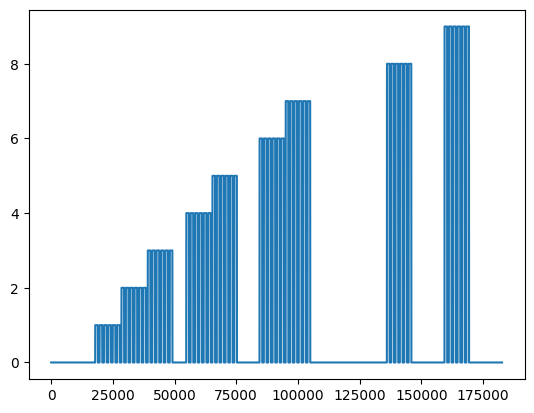

In [ ]:
plt.plot(list_label_x_sujeto[0])

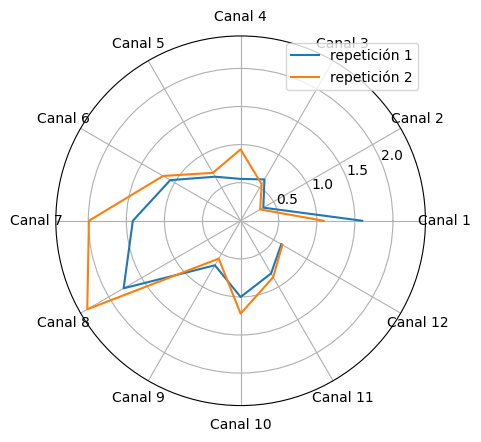

In [ ]:
# calculo std de repetición

i = 0
sig = data[(rep_starts_ind[i]+1): (rep_ends_ind[i]+1)]

std_x_canal = np.std(sig, axis=0)

i = 1
sig1 = data[(rep_starts_ind[i]+1): (rep_ends_ind[i]+1)]

std_x_canal1 = np.std(sig1, axis=0)


# Crear un gráfico polar
fig = plt.figure()
ax = fig.add_subplot(111, projection='polar')

# Ángulos para cada canal
theta = np.linspace(0, 2*np.pi, len(std_x_canal), endpoint=False)

# Graficar los datos
ax.plot(theta, std_x_canal, label = 'repetición 1')
# Graficar los datos
ax.plot(theta, std_x_canal1, label = 'repetición 2')

# Especificar la cantidad de ticks manualmente para que coincida con la cantidad de etiquetas.
ax.set_xticks(theta)

# Definir las etiquetas para los ticks.
labels = ['Canal 1', 'Canal 2', 'Canal 3', 'Canal 4', 'Canal 5', 'Canal 6', 'Canal 7', 'Canal 8', 'Canal 9', 'Canal 10', 'Canal 11', 'Canal 12']

# Establecer las etiquetas de los ticks.
ax.set_xticklabels(labels)

# Añadir una leyenda
ax.legend(loc='upper right')

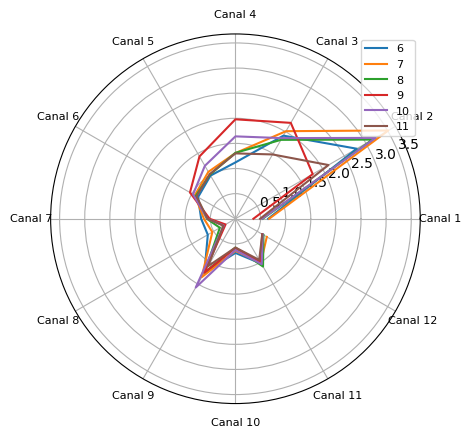

In [ ]:
# Crear un gráfico polar
fig = plt.figure()
ax = fig.add_subplot(111, projection='polar')

for i in range(6, 12):
  sig = data[(rep_starts_ind[i]+1): (rep_ends_ind[i]+1)]
  std_x_canal = np.std(sig, axis=0)

  # Ángulos para cada canal
  theta = np.linspace(0, 2*np.pi, len(std_x_canal), endpoint=False) # va a ser el mismo en todas las iteraciones

  # Graficar los datos
  ax.plot(theta, std_x_canal, label = str(i))

# Especificar la cantidad de ticks manualmente para que coincida con la cantidad de etiquetas.
ax.set_xticks(theta)

# Definir las etiquetas para los ticks.
labels = ['Canal 1', 'Canal 2', 'Canal 3', 'Canal 4', 'Canal 5', 'Canal 6', 'Canal 7', 'Canal 8', 'Canal 9', 'Canal 10', 'Canal 11', 'Canal 12']

# Establecer las etiquetas de los ticks.
ax.set_xticklabels(labels, fontsize=8)

# Añadir una leyenda
ax.legend(loc='upper right', fontsize=8)

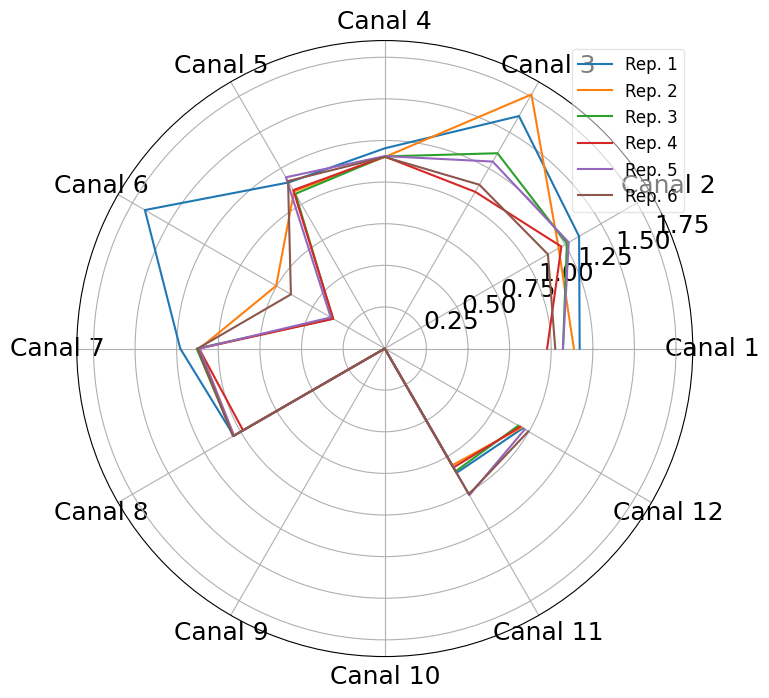

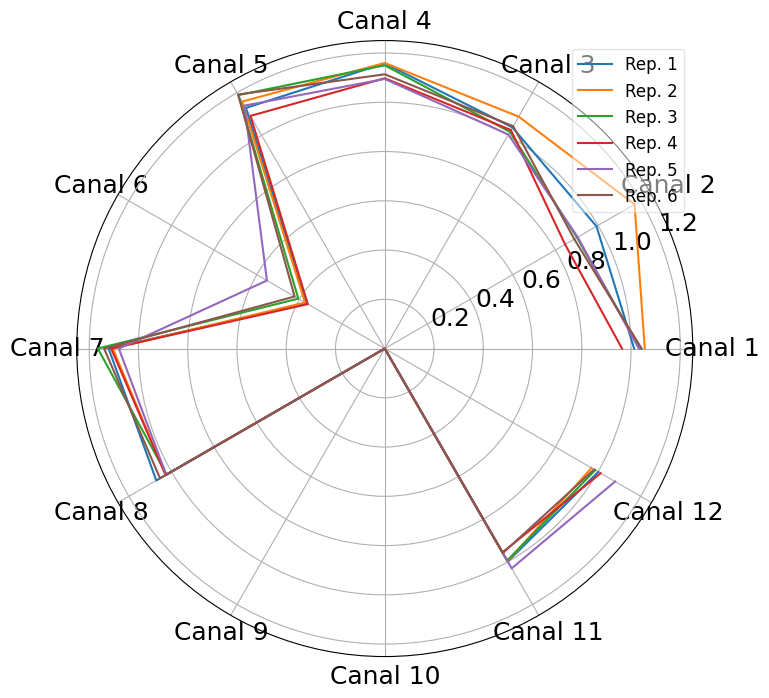

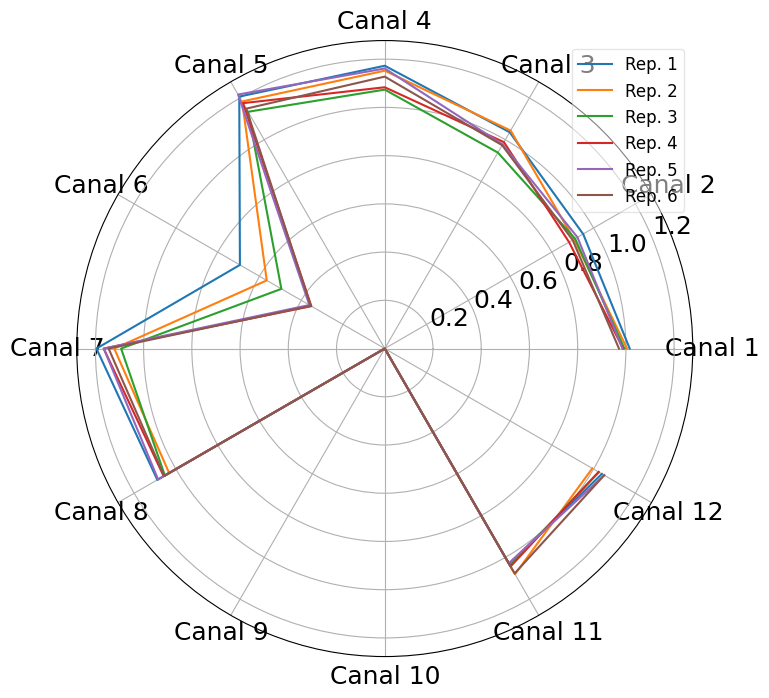

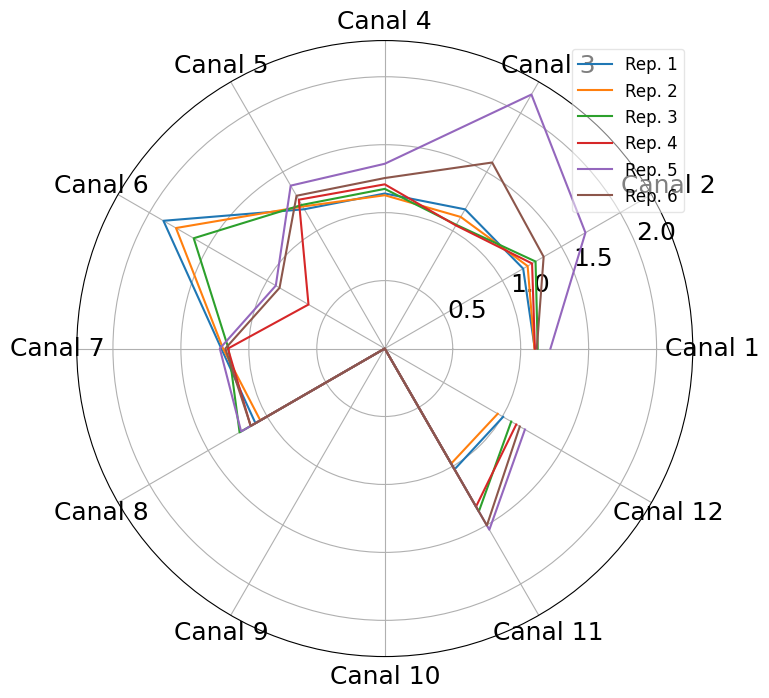

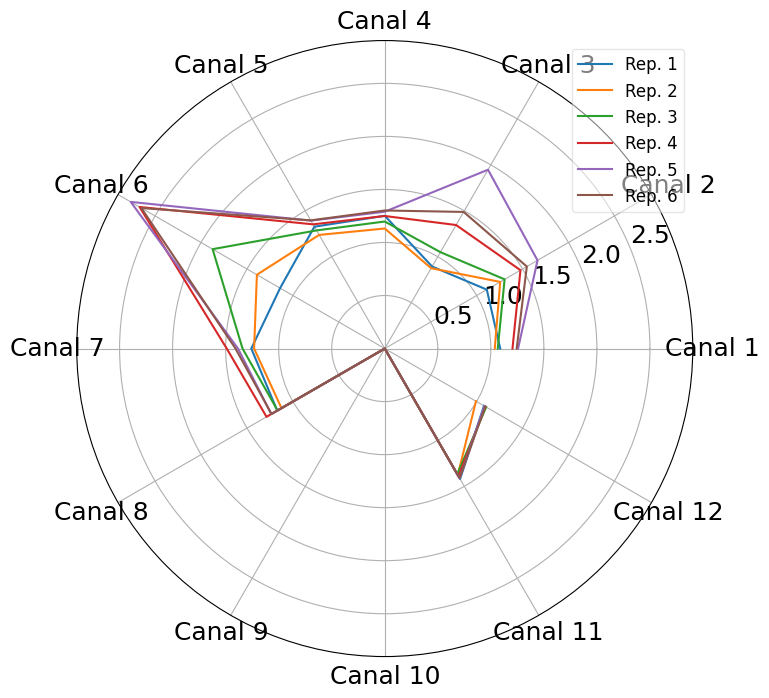

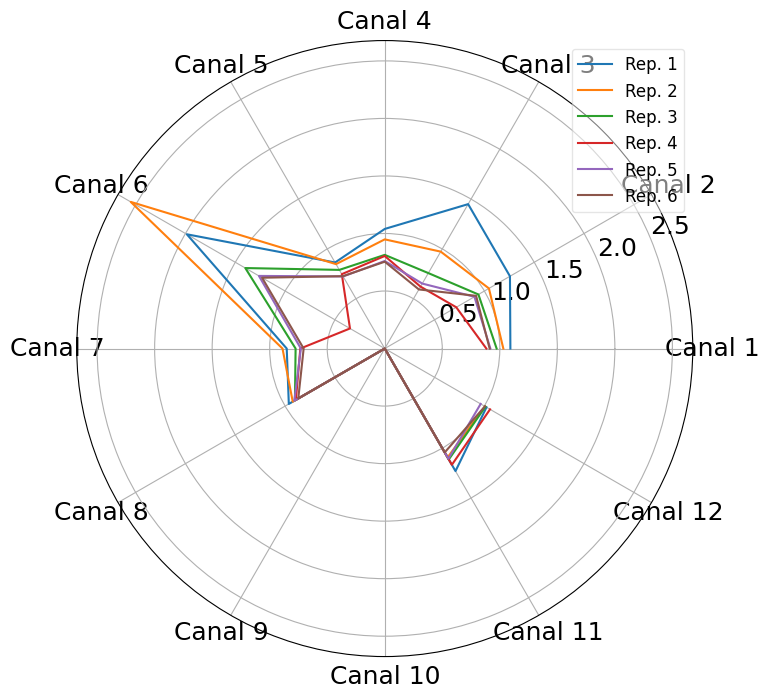

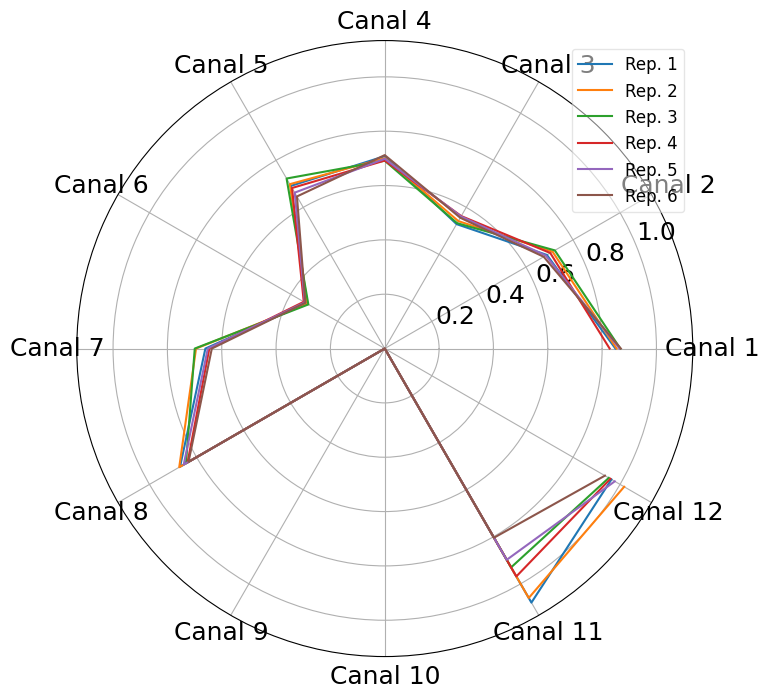

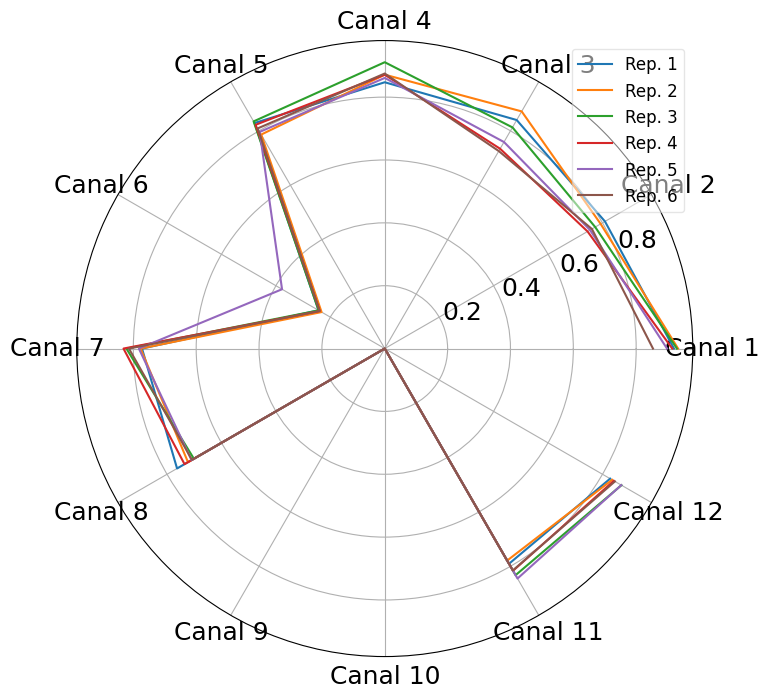

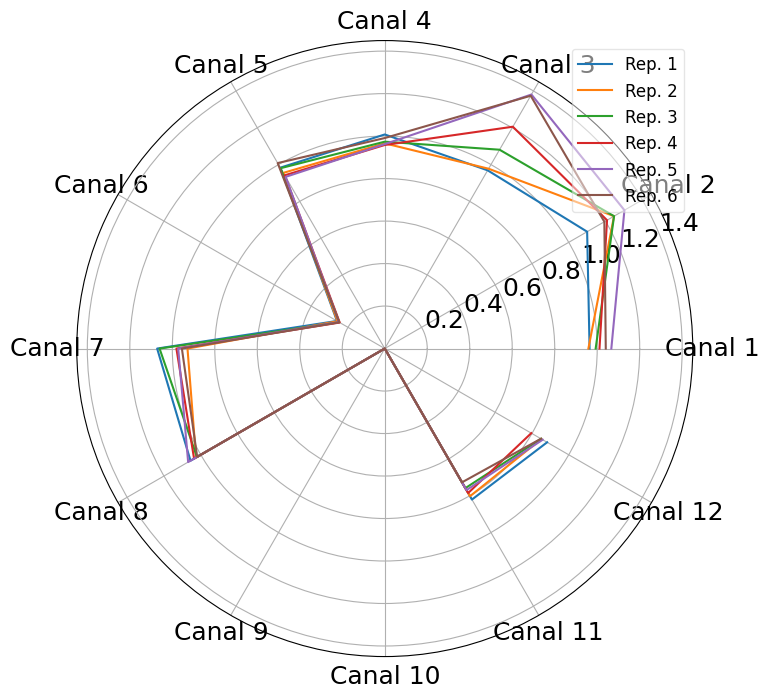

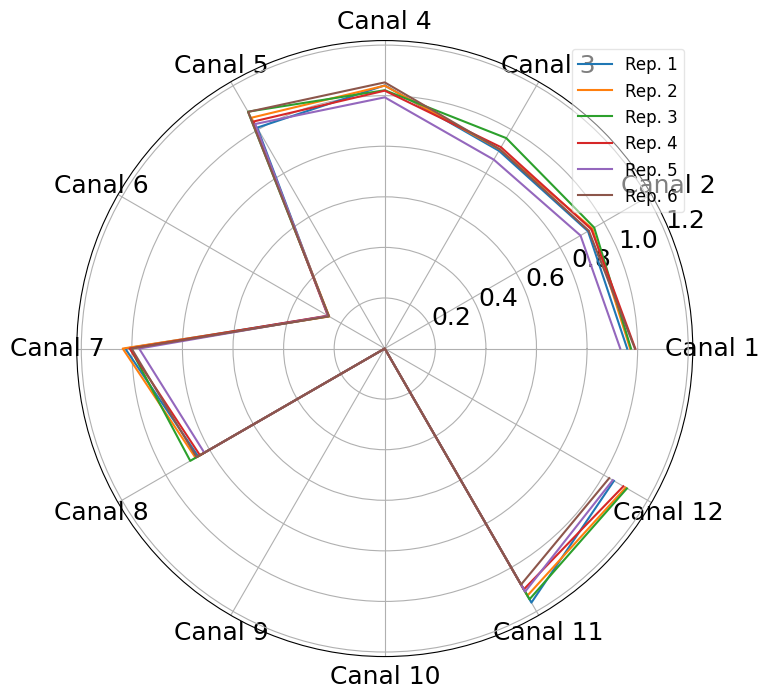

In [ ]:
# elijo sujeto
j = 5

data_j = list_data_x_sujeto[j]
label_j = list_label_x_sujeto[j]

flancos = np.diff(label_j)  # Con estos flancos puedo dividir las repeticiones
rep_starts_ind = np.where(flancos>0)[0]
rep_ends_ind = np.where(flancos<0)[0]

etiqueta_repeticion = []
indices_repeticion = []

etiqueta_repeticion = label_j[rep_ends_ind]

# defino cantidad de gestos. esto en realidad podria sacarlo de etiqueta_repeticion directo
cant_gestos = 10

for i in range(1, cant_gestos + 1):
    ind_reps = np.where(etiqueta_repeticion == i)[0]
    # Crear un gráfico polar
    fig = plt.figure(figsize=(8, 8))  # Ajustar el tamaño de la figura para mejor proporción
    ax = fig.add_subplot(111, projection='polar')

    for idx, k in enumerate(ind_reps):
        sig = data_j[(rep_starts_ind[k] + 1): (rep_ends_ind[k] + 1)]
        std_x_canal = np.std(sig, axis=0)

        # Ángulos para cada canal
        theta = np.linspace(0, 2 * np.pi, len(std_x_canal), endpoint=False)

        # Graficar los datos
        ax.plot(theta, std_x_canal, label=f"Rep. {idx + 1}")

    # Especificar la cantidad de ticks manualmente para que coincida con la cantidad de etiquetas
    ax.set_xticks(theta)

    # Definir las etiquetas para los ticks
    labels = [f'Canal {j + 1}' for j in range(len(std_x_canal))]

    # Establecer las etiquetas de los ticks con tamaño 18
    ax.set_xticklabels(labels, fontsize=18)

    # Ajustar el tamaño de los números del eje radial (valores del eje polar)
    ax.tick_params(axis='y', labelsize=18)

    # Título con tamaño 18
    # ax.set_title(f"Gesto {i}", fontsize=18, fontweight='bold')

    # Añadir una leyenda con tamaño 18
    ax.legend(loc='upper right', fontsize=12, framealpha=0.5)

    # Guardar como PDF
    plt.savefig(f"Gesto_{i}_sujeto{j}.pdf", format="pdf", bbox_inches="tight")

    # Mostrar la imagen en pantalla
    plt.show()

    # Cerrar la figura para liberar memoria
    plt.close(fig)



In [ ]:

for i in range(1, cant_gestos + 1):
    ind_reps = np.where(etiqueta_repeticion == i)[0]
    # Crear un gráfico polar
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='polar')

    for idx, k in enumerate(ind_reps):
        sig = data_j[(rep_starts_ind[k] + 1): (rep_ends_ind[k] + 1)]
        std_x_canal = np.std(sig, axis=0)

        # Ángulos para cada canal
        theta = np.linspace(0, 2 * np.pi, len(std_x_canal), endpoint=False)

        # Graficar los datos
        ax.plot(theta, std_x_canal, label=f"Repetición {idx + 1}")

    # Especificar la cantidad de ticks manualmente para que coincida con la cantidad de etiquetas
    ax.set_xticks(theta)

    # Definir las etiquetas para los ticks
    labels = [f'Canal {j + 1}' for j in range(len(std_x_canal))]

    # Establecer las etiquetas de los ticks
    ax.set_xticklabels(labels, fontsize=28)

    # Título
    ax.set_title(f"Gesto {i}", fontsize=30, fontweight='bold')

    # Añadir una leyenda
    ax.legend(loc='upper right', fontsize=28)

    # Guardar como PDF
    plt.savefig(f"Gesto_{i}.pdf", format="pdf", bbox_inches="tight")

    # Cerrar la figura para liberar memoria
    plt.close(fig)


<ipython-input-17-6f5fea76c94d>:30: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='upper right', fontsize=28)


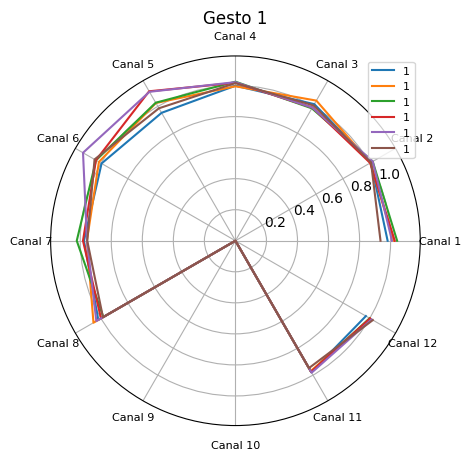

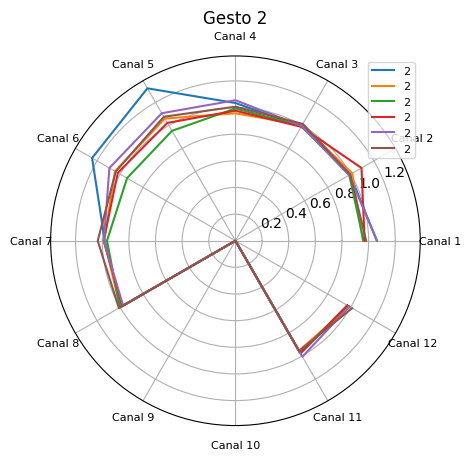

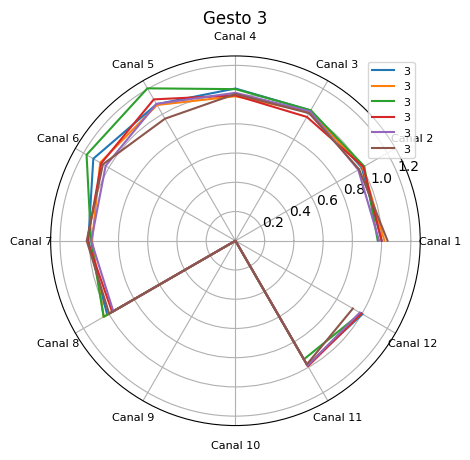

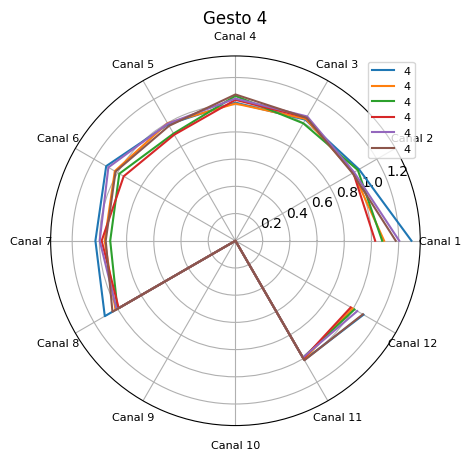

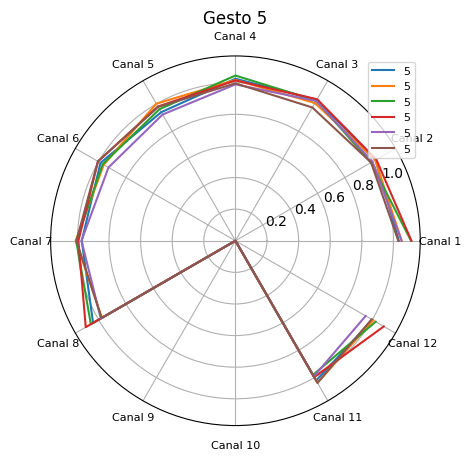

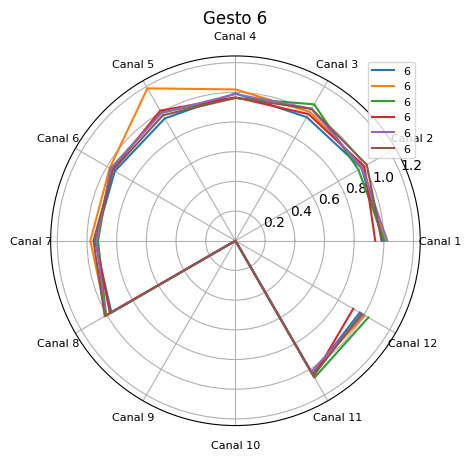

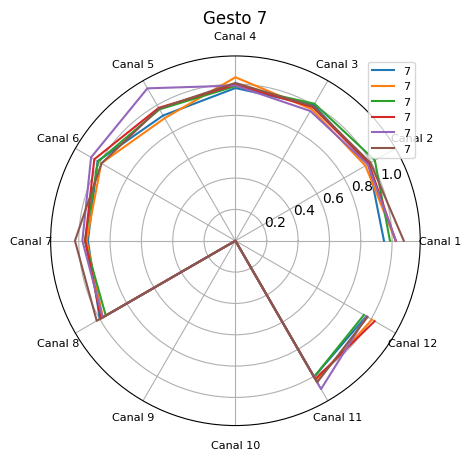

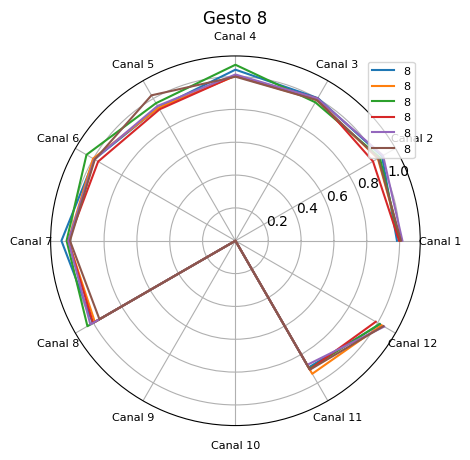

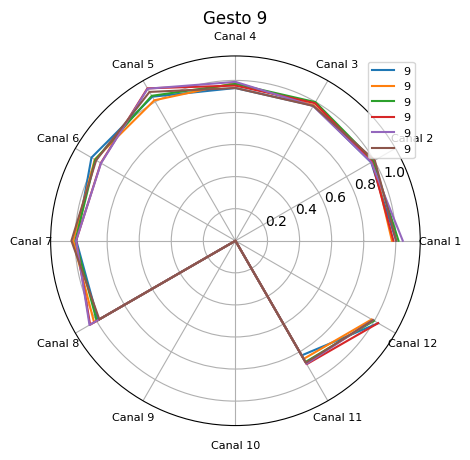

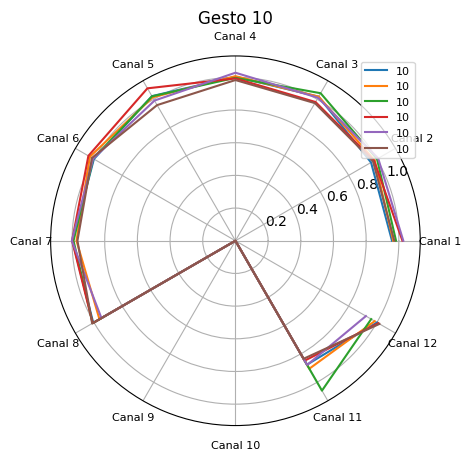

In [ ]:
# elijo sujeto
j = 6

data_j = list_data_x_sujeto[j]
label_j = list_label_x_sujeto[j]

flancos = np.diff(label_j)  # Con estos flancos puedo dividir las repeticiones
rep_starts_ind = np.where(flancos>0)[0]
rep_ends_ind = np.where(flancos<0)[0]

etiqueta_repeticion = []
indices_repeticion = []

etiqueta_repeticion = label_j[rep_ends_ind]

# defino cantidad de gestos. esto en realidad podria sacarlo de etiqueta_repeticion directo
cant_gestos = 10

for i in range(1, cant_gestos+1):
  ind_reps = np.where(etiqueta_repeticion==i)[0]
  # Crear un gráfico polar
  fig = plt.figure()
  ax = fig.add_subplot(111, projection='polar')

  for k in ind_reps:
    sig = data_j[(rep_starts_ind[k]+1): (rep_ends_ind[k]+1)]
    std_x_canal = np.std(sig, axis=0)

    # Ángulos para cada canal
    theta = np.linspace(0, 2*np.pi, len(std_x_canal), endpoint=False) # va a ser el mismo en todas las iteraciones

    # Graficar los datos
    ax.plot(theta, std_x_canal, label = str(i))

  # Especificar la cantidad de ticks manualmente para que coincida con la cantidad de etiquetas.
  ax.set_xticks(theta)
  # Definir las etiquetas para los ticks.
  labels = ['Canal 1', 'Canal 2', 'Canal 3', 'Canal 4', 'Canal 5', 'Canal 6', 'Canal 7', 'Canal 8', 'Canal 9', 'Canal 10', 'Canal 11', 'Canal 12']

  # Establecer las etiquetas de los ticks.
  ax.set_xticklabels(labels, fontsize=8)
  ax.set_title("Gesto "+str(i))

  # Añadir una leyenda
  ax.legend(loc='upper right', fontsize=8)

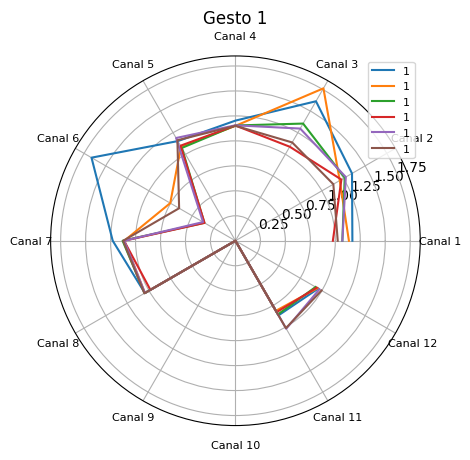

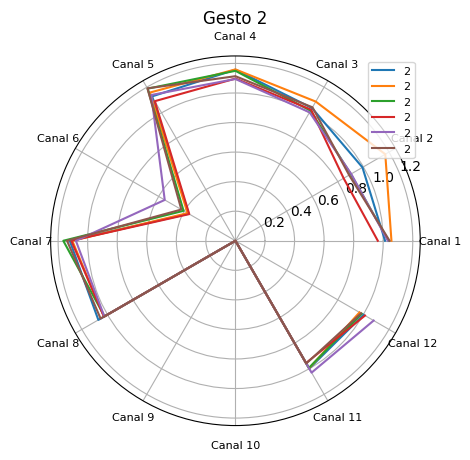

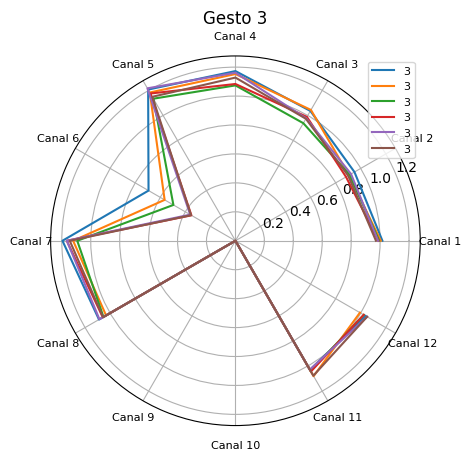

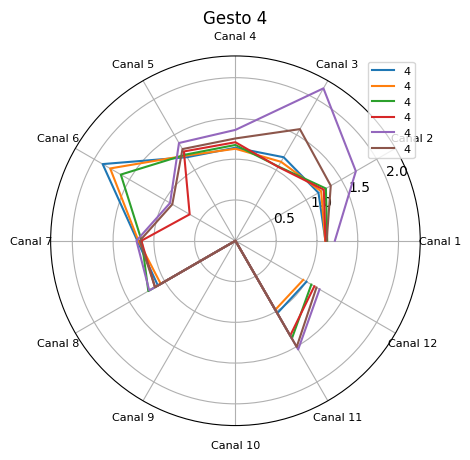

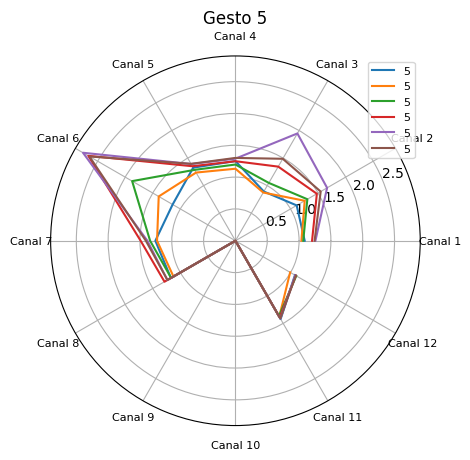

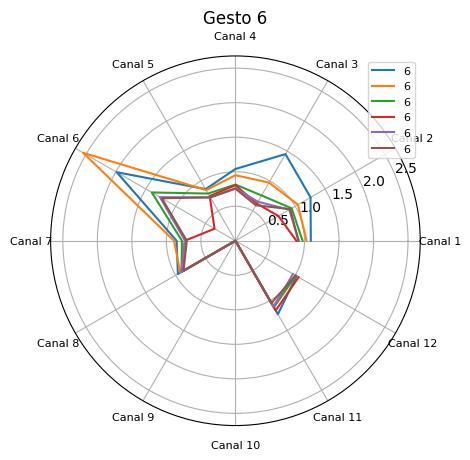

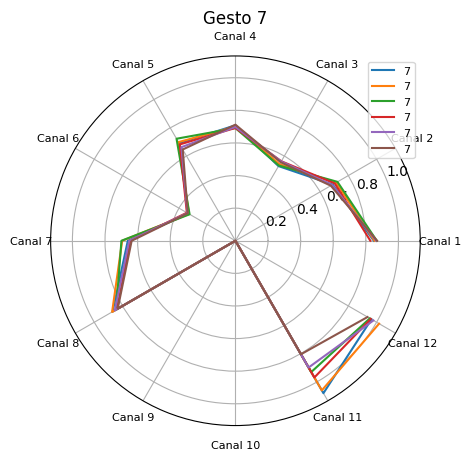

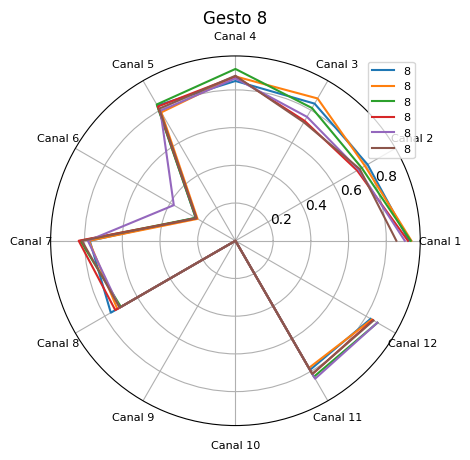

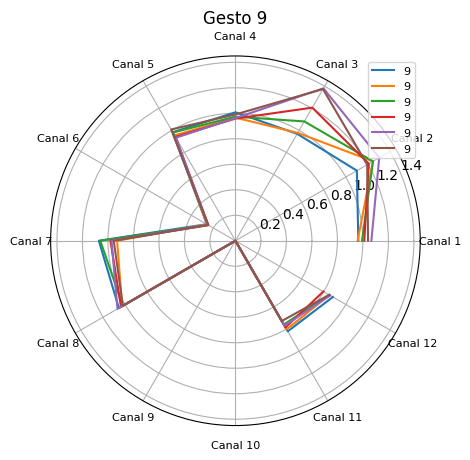

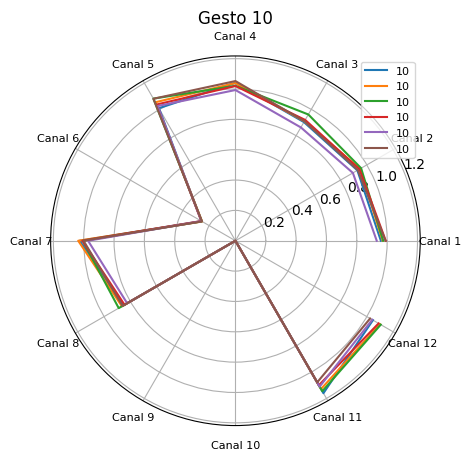

In [ ]:
# elijo sujeto
j = 5

data_j = list_data_x_sujeto[j]
label_j = list_label_x_sujeto[j]

flancos = np.diff(label_j)  # Con estos flancos puedo dividir las repeticiones
rep_starts_ind = np.where(flancos>0)[0]
rep_ends_ind = np.where(flancos<0)[0]

etiqueta_repeticion = []
indices_repeticion = []

etiqueta_repeticion = label_j[rep_ends_ind]

# defino cantidad de gestos. esto en realidad podria sacarlo de etiqueta_repeticion directo
cant_gestos = 10

for i in range(1, cant_gestos+1):
  ind_reps = np.where(etiqueta_repeticion==i)[0]
  # Crear un gráfico polar
  fig = plt.figure()
  ax = fig.add_subplot(111, projection='polar')

  for k in ind_reps:
    sig = data_j[(rep_starts_ind[k]+1): (rep_ends_ind[k]+1)]
    std_x_canal = np.std(sig, axis=0)

    # Ángulos para cada canal
    theta = np.linspace(0, 2*np.pi, len(std_x_canal), endpoint=False) # va a ser el mismo en todas las iteraciones

    # Graficar los datos
    ax.plot(theta, std_x_canal, label = str(i))

  # Especificar la cantidad de ticks manualmente para que coincida con la cantidad de etiquetas.
  ax.set_xticks(theta)
  # Definir las etiquetas para los ticks.
  labels = ['Canal 1', 'Canal 2', 'Canal 3', 'Canal 4', 'Canal 5', 'Canal 6', 'Canal 7', 'Canal 8', 'Canal 9', 'Canal 10', 'Canal 11', 'Canal 12']

  # Establecer las etiquetas de los ticks.
  ax.set_xticklabels(labels, fontsize=8)
  ax.set_title("Gesto "+str(i))

  # Añadir una leyenda
  ax.legend(loc='upper right', fontsize=8)